In [1]:
from mplfinance.original_flavor import candlestick_ohlc
import yfinance as yf
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import scipy
from pandas.plotting import autocorrelation_plot
import requests
from datetime import datetime
import pandas as pd
import warnings
import hvplot.pandas
import hvplot as hv
import numpy as np
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
from scipy.stats import boxcox
from statsmodels.tsa.stattools import kpss
from scipy.stats import shapiro, kstest, normaltest
from statsmodels.stats.diagnostic import kstest_normal, normal_ad
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize              
import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from itertools import product
from tqdm import tqdm_notebook
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")

# META

In [2]:
def get_price_data(ticker='META'):
    tickerData = yf.Ticker(ticker)
    tickerDf = tickerData.history(period='1d', start='2017-1-1', end='2023-1-1')
    return tickerDf.iloc[:,:5]

In [3]:
def plot_candlestick(df, ax=None, fmt="%Y-%m-%d"):
    if ax is None:
        fig, ax = plt.subplots()
    idx_name = df.index.name if df.index.name else 'index'
    dat = df.reset_index()[[idx_name, "Open", "High", "Low", "Close"]]
    dat[idx_name] = dat[idx_name].map(mdates.date2num)
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter(fmt))
    plt.xticks(rotation=45)
    _ = candlestick_ohlc(ax, dat.values, width=.6, colorup='g', alpha =1)
    ax.set_xlabel(idx_name)
    ax.set_ylabel("OHLC")
    return ax

In [4]:
def is_normal(test, p_level=0.05):
    stat, pval = test
    return 'Normal' if pval > 0.05 else 'Not Normal'

In [5]:
def adfuller_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    

In [6]:
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [7]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    adfuller_stationarity(y)
    kpss_test(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()

In [8]:
 def series_decompose(series):
    result = seasonal_decompose(series, model='multiplicative', period=365)

    plt.figure(figsize=(12, 8))
    
    plt.subplot(4, 1, 1)
    plt.plot(series, label='Original')
    plt.legend()
    
    plt.subplot(4, 1, 2)
    plt.plot(result.trend, label='Trend')
    plt.legend()
    
    plt.subplot(4, 1, 3)
    plt.plot(result.seasonal, label='Seasonal')
    plt.legend()
    
    plt.subplot(4, 1, 4)
    plt.plot(result.resid, label='Residuals')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [9]:
meta_df = get_price_data()

In [10]:
meta_df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03 00:00:00-05:00,116.029999,117.839996,115.510002,116.860001,20663900
2017-01-04 00:00:00-05:00,117.550003,119.660004,117.290001,118.690002,19630900
2017-01-05 00:00:00-05:00,118.860001,120.949997,118.320000,120.669998,19492200
2017-01-06 00:00:00-05:00,120.980003,123.879997,120.029999,123.410004,28545300
2017-01-09 00:00:00-05:00,123.550003,125.430000,123.040001,124.900002,22880400


In [11]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1510 entries, 2017-01-03 00:00:00-05:00 to 2022-12-30 00:00:00-05:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1510 non-null   float64
 1   High    1510 non-null   float64
 2   Low     1510 non-null   float64
 3   Close   1510 non-null   float64
 4   Volume  1510 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 70.8 KB


<Axes: xlabel='Close', ylabel='Count'>

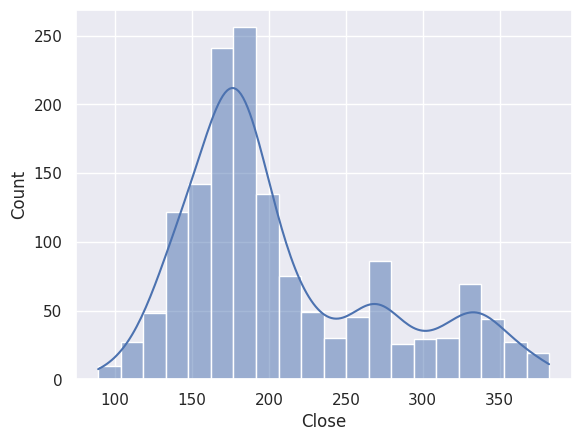

In [13]:
sns.histplot(meta_df,x='Close',kde=True)

In [14]:
print(is_normal(shapiro(meta_df['Close'])))
print(is_normal(kstest_normal(meta_df['Close'])))

Not Normal
Not Normal


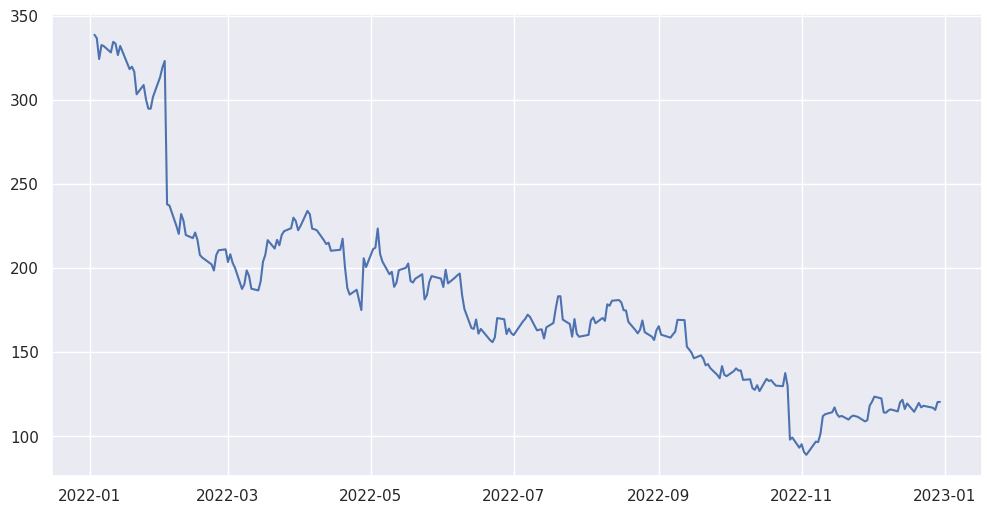

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(meta_df['2022-1-1':'2022-12-30']['Close'])
plt.show()

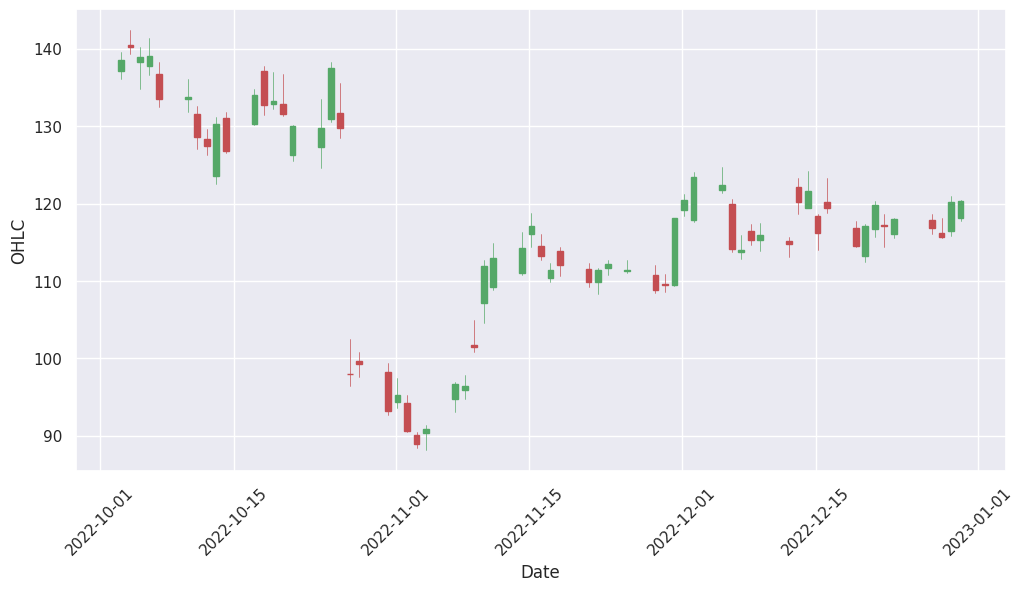

In [16]:
fig = plt.figure(figsize=(12,6))
plot_candlestick(meta_df['2022-10-1':'2022-12-30'], fig.subplots())
plt.show()

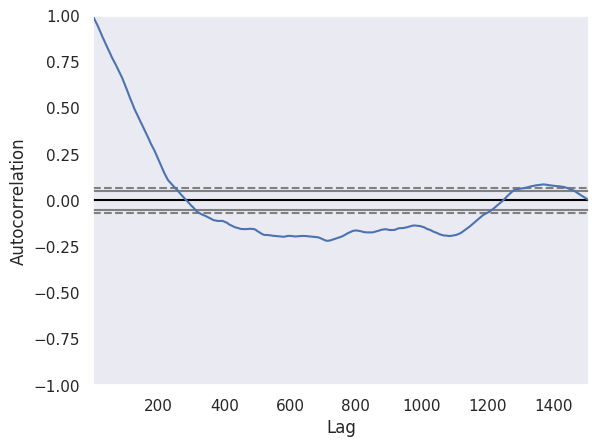

In [17]:
autocorrelation_plot(meta_df['Close'])
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                   -1.270556
p-value                           0.642533
#Lags Used                        9.000000
Number of Observations Used    1500.000000
Critical Value (1%)              -3.434717
Critical Value (5%)              -2.863469
Critical Value (10%)             -2.567797
dtype: float64
Results of KPSS Test:
Test Statistic            2.061724
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


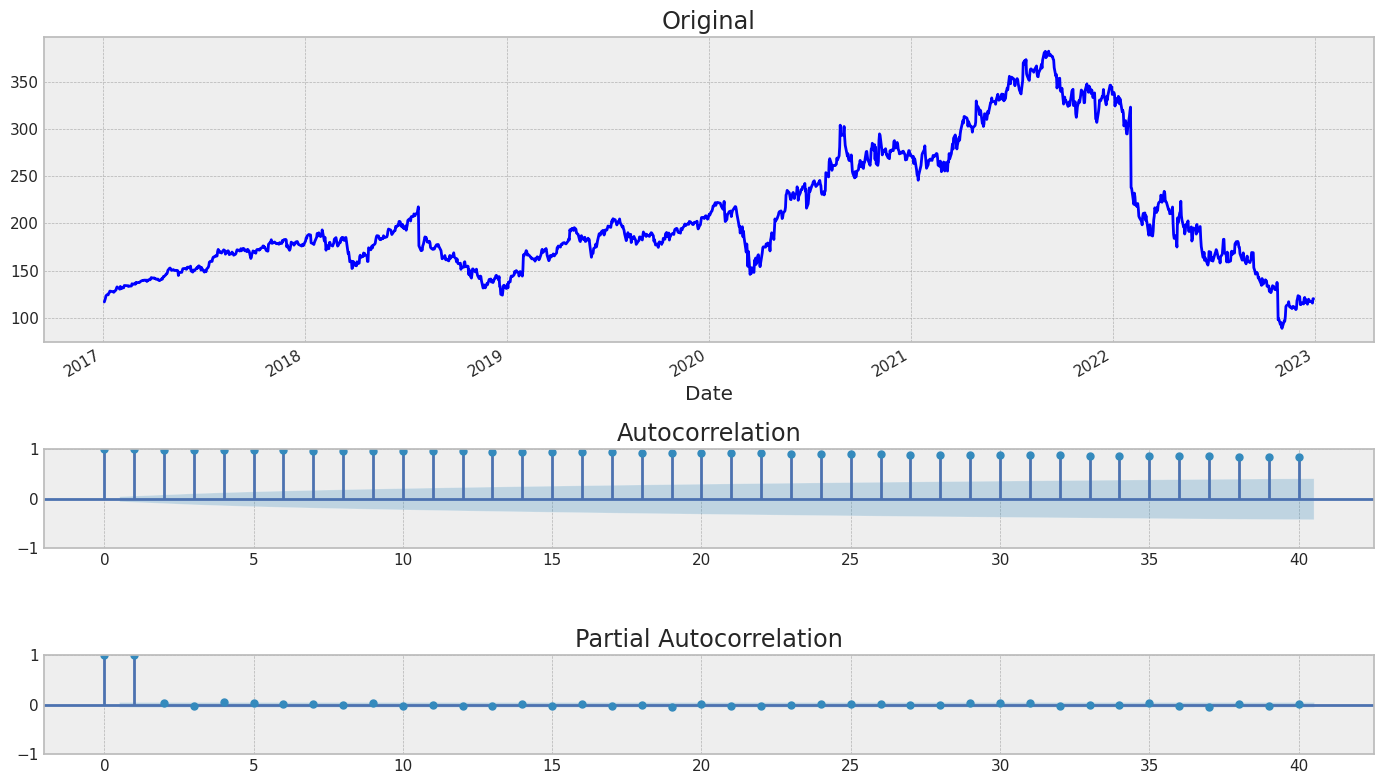

In [18]:
tsplot(meta_df['Close'],lags=40)

In [19]:
meta_df['Close'].hvplot.line(title="META daily close price 2017-2023", width=1300, height=600, by=['index.year'])

:NdOverlay   [index.year]
   :Curve   [Date]   (Close)

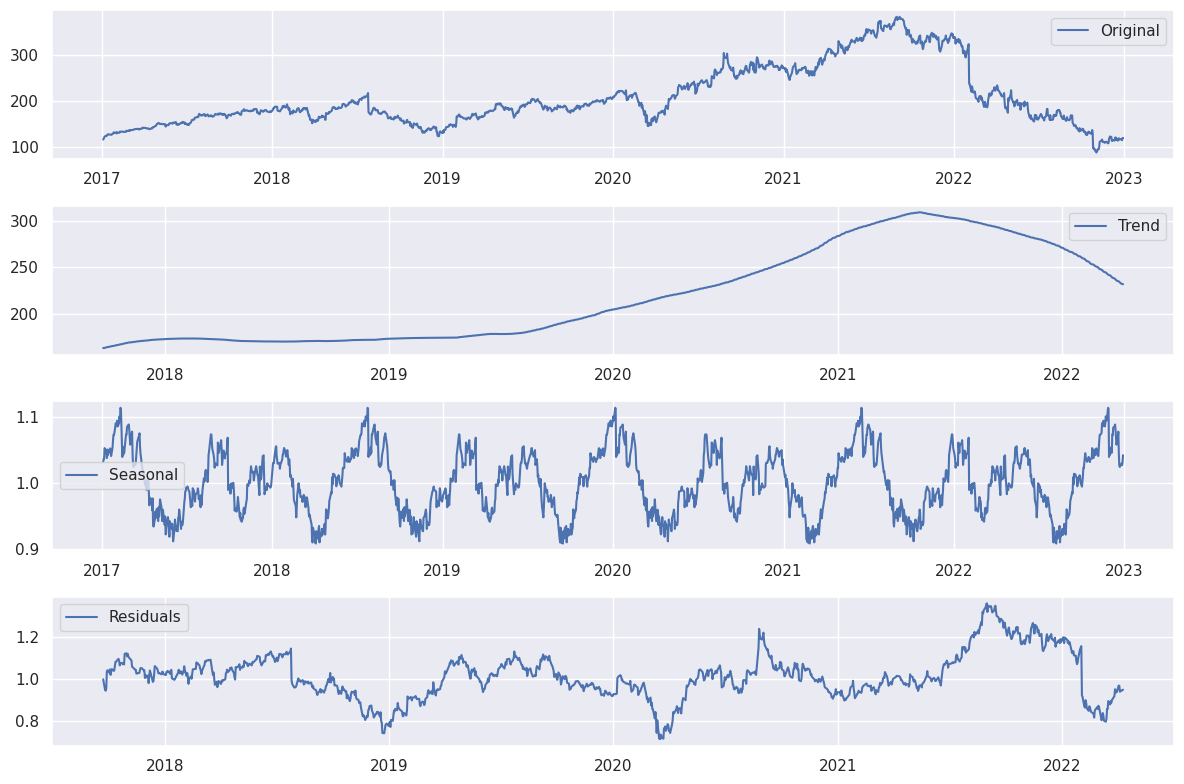

In [20]:
series_decompose(meta_df['Close'])

## Make stationarity

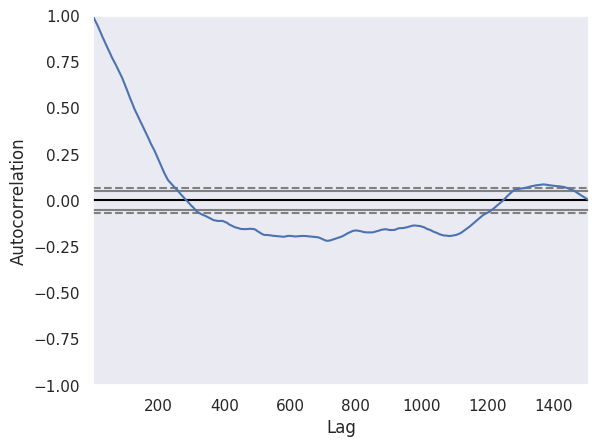

In [21]:
autocorrelation_plot(meta_df['Close'])
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                   -1.270556
p-value                           0.642533
#Lags Used                        9.000000
Number of Observations Used    1500.000000
Critical Value (1%)              -3.434717
Critical Value (5%)              -2.863469
Critical Value (10%)             -2.567797
dtype: float64
Results of KPSS Test:
Test Statistic            2.061724
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


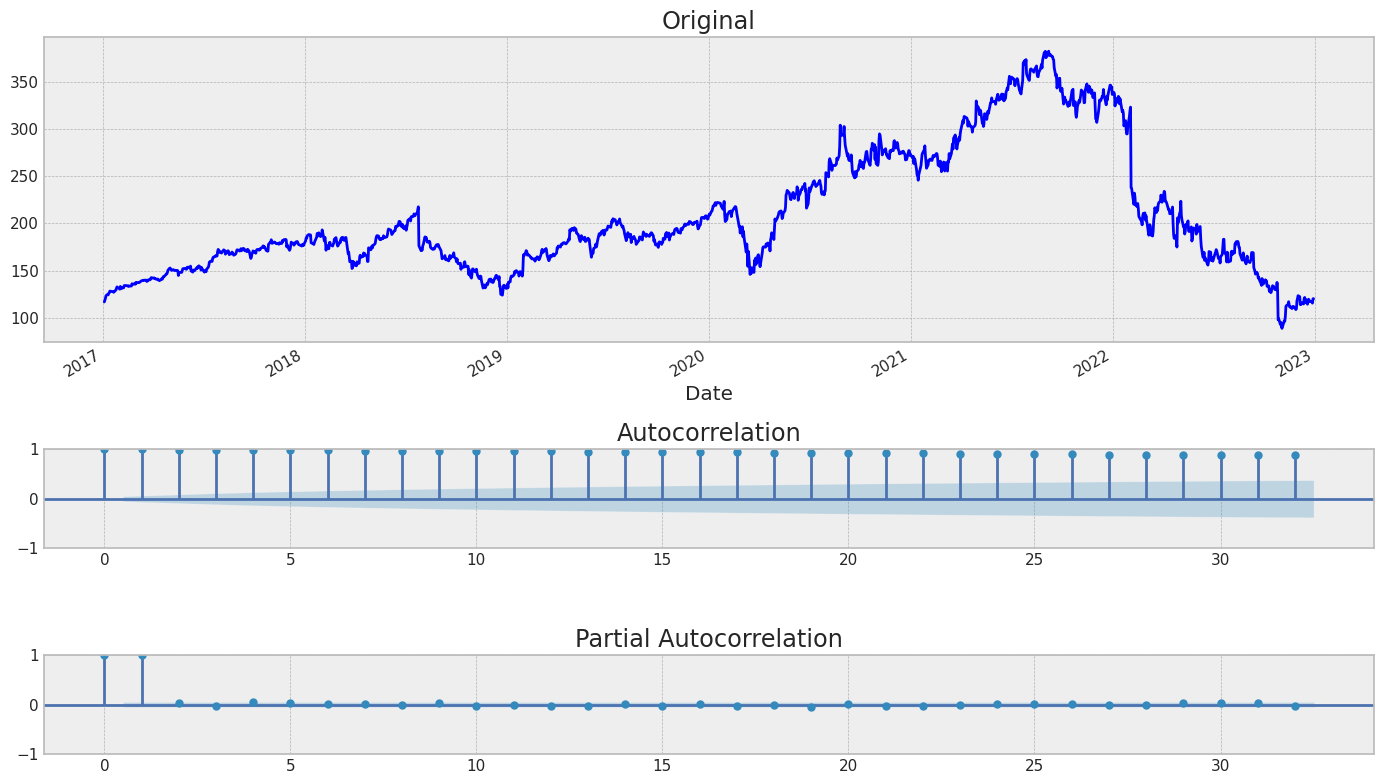

In [22]:
tsplot(meta_df['Close'])

Results of Dickey-Fuller Test:
Test Statistic                   -1.270556
p-value                           0.642533
#Lags Used                        9.000000
Number of Observations Used    1500.000000
Critical Value (1%)              -3.434717
Critical Value (5%)              -2.863469
Critical Value (10%)             -2.567797
dtype: float64
Results of KPSS Test:
Test Statistic            2.061724
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


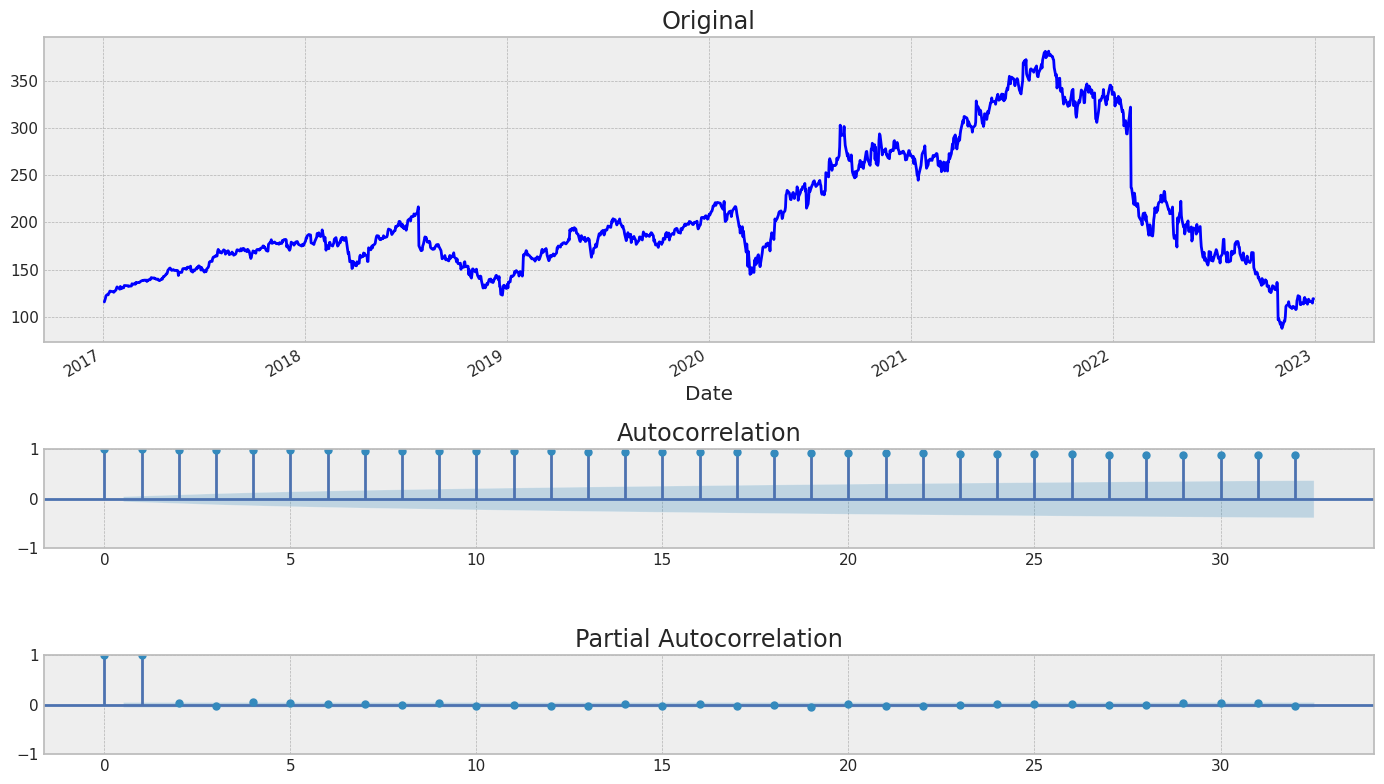

In [23]:
meta_df['Close_boxcox'] = boxcox(meta_df['Close'], 1)
tsplot(meta_df['Close_boxcox'])


Results of Dickey-Fuller Test:
Test Statistic                   -1.239600
p-value                           0.656333
#Lags Used                       10.000000
Number of Observations Used    1499.000000
Critical Value (1%)              -3.434720
Critical Value (5%)              -2.863470
Critical Value (10%)             -2.567798
dtype: float64
Results of KPSS Test:
Test Statistic            1.910976
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


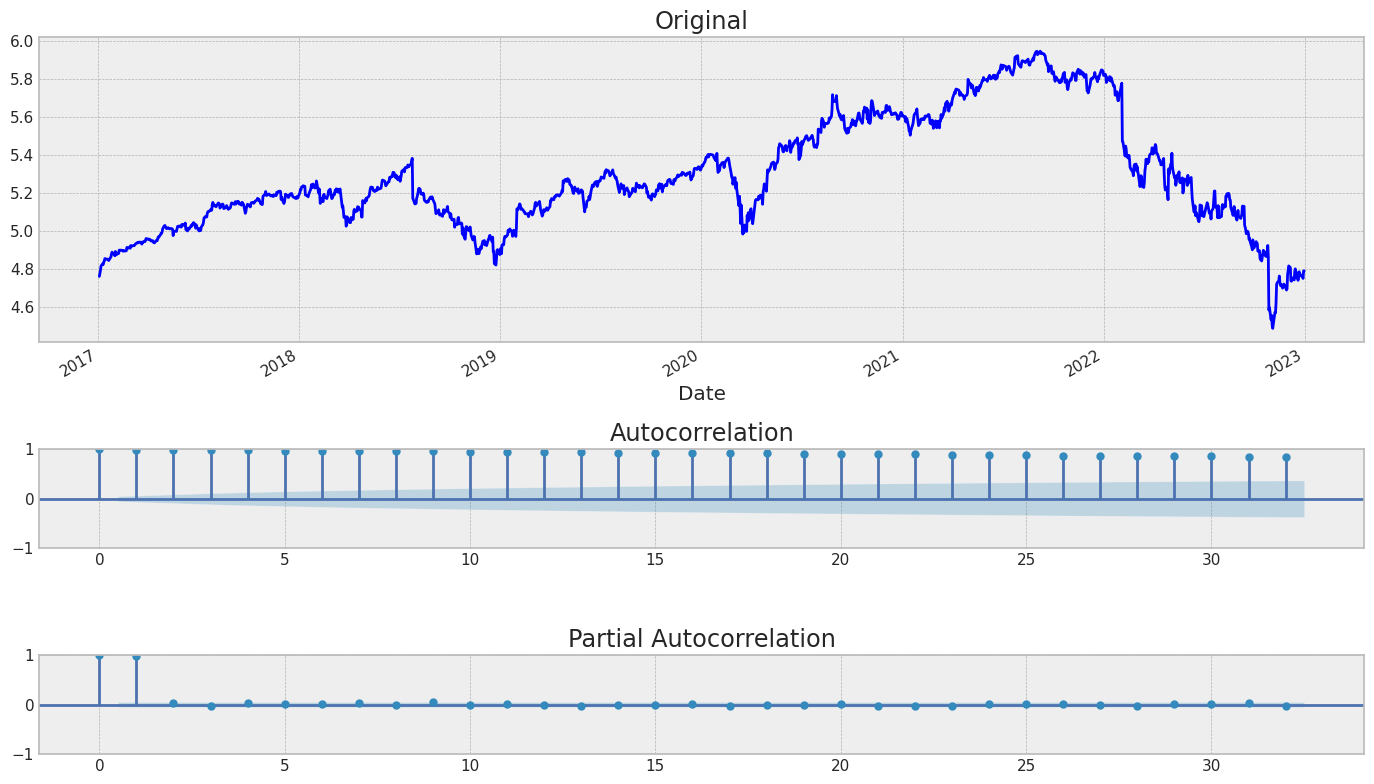

In [24]:
meta_df['Close_log'] = np.log(meta_df['Close'])
tsplot(meta_df['Close_log'])

Results of Dickey-Fuller Test:
Test Statistic                -1.377230e+01
p-value                        9.631894e-26
#Lags Used                     8.000000e+00
Number of Observations Used    1.501000e+03
Critical Value (1%)           -3.434714e+00
Critical Value (5%)           -2.863467e+00
Critical Value (10%)          -2.567796e+00
dtype: float64
Results of KPSS Test:
Test Statistic            0.357763
p-value                   0.095361
#Lags Used               14.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


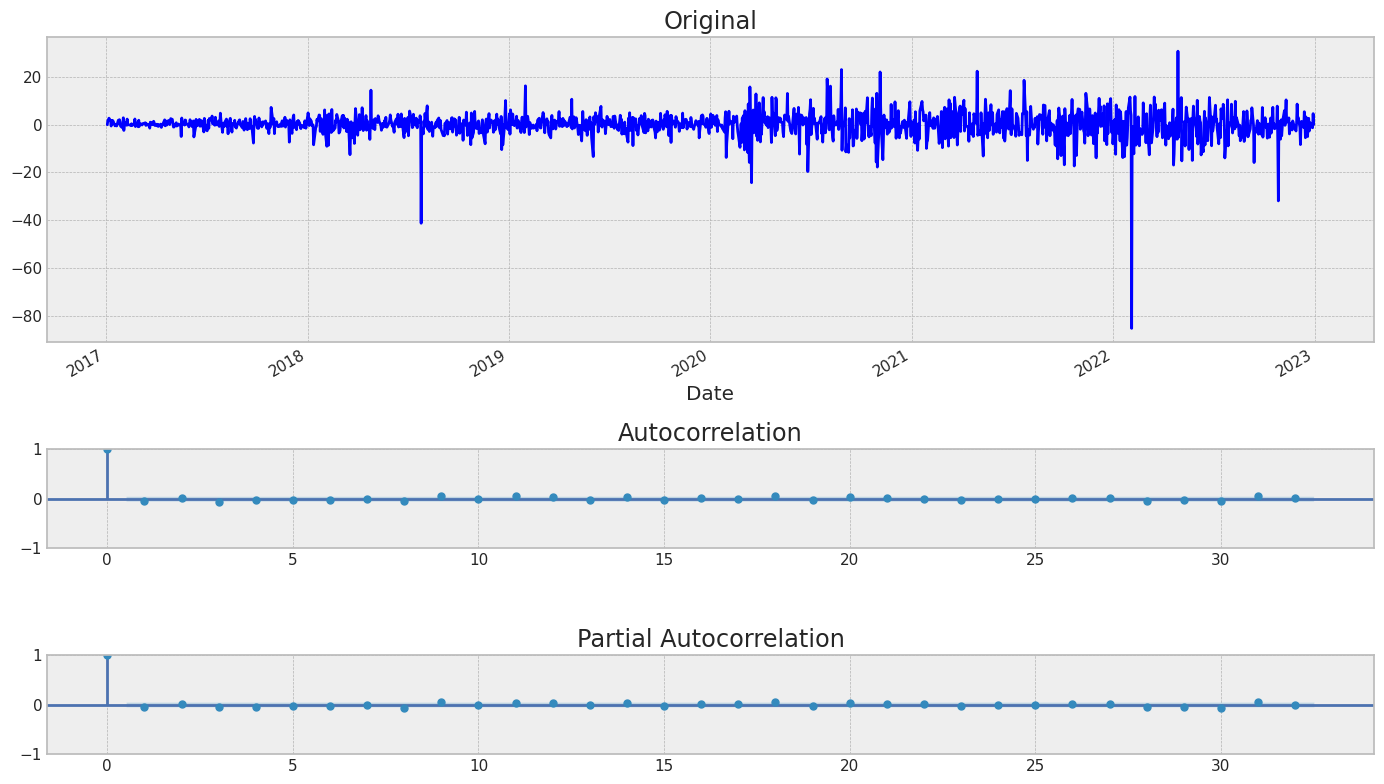

In [25]:
meta_diff = np.diff(meta_df['Close'],1)
meta_df['Close_diff'] = np.append(0,meta_diff)
tsplot(meta_df['Close_diff'])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

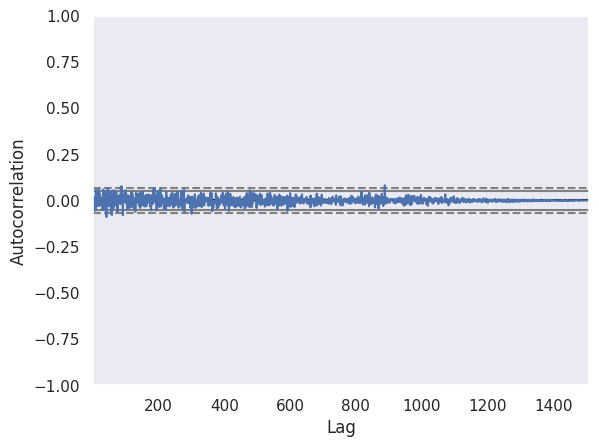

In [26]:
autocorrelation_plot(meta_df['Close_diff'])

# NFLX

In [27]:
nflx_df = get_price_data(ticker='NFLX')

In [28]:
nflx_df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03 00:00:00-05:00,124.959999,128.190002,124.309998,127.489998,9437900
2017-01-04 00:00:00-05:00,127.489998,130.169998,126.550003,129.410004,7843600
2017-01-05 00:00:00-05:00,129.220001,132.750000,128.899994,131.809998,10185500
2017-01-06 00:00:00-05:00,132.080002,133.880005,129.809998,131.070007,10657900
2017-01-09 00:00:00-05:00,131.479996,131.990005,129.889999,130.949997,5771800


In [29]:
nflx_df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

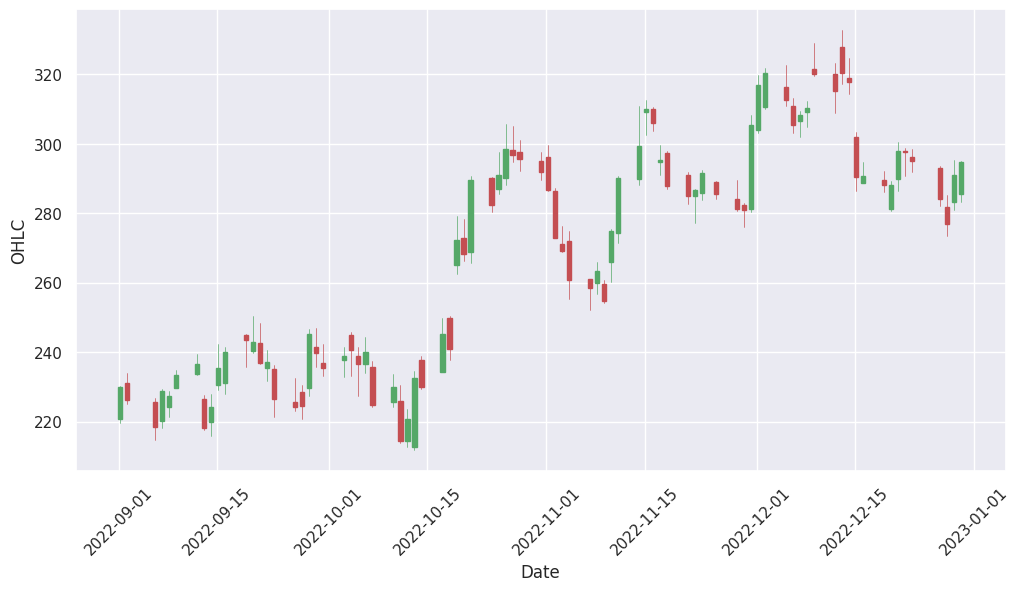

In [30]:
fig = plt.figure(figsize=(12,6))
plot_candlestick(nflx_df['2022-9-1':'2023-1-1'], fig.subplots())
plt.show()

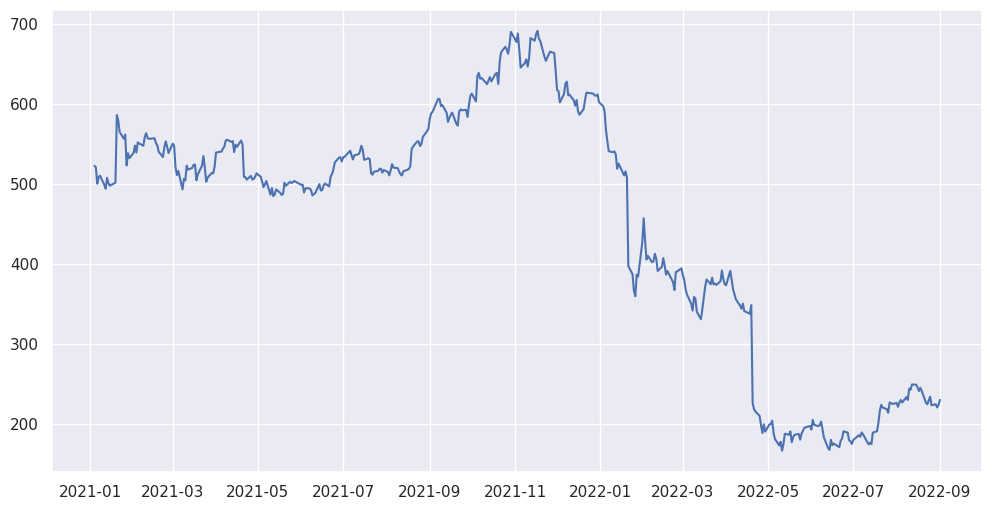

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(nflx_df['2021-1-1':'2022-9-1']['Close'])
plt.show()

In [32]:
nflx_df['Close'].hvplot.line(title="NFLX daily close price 2017-2023", width=1300, height=600, by=['index.year'])

:NdOverlay   [index.year]
   :Curve   [Date]   (Close)

<Axes: xlabel='Close', ylabel='Count'>

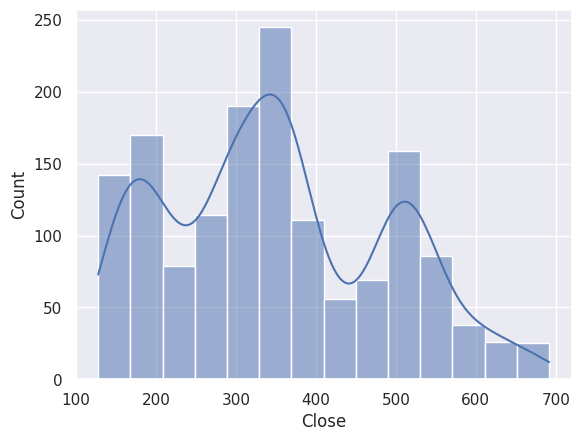

In [33]:
sns.histplot(nflx_df,x='Close',kde=True)

In [34]:
print(is_normal(shapiro(nflx_df['Close'])))
print(is_normal(kstest_normal(nflx_df['Close'])))

Not Normal
Not Normal


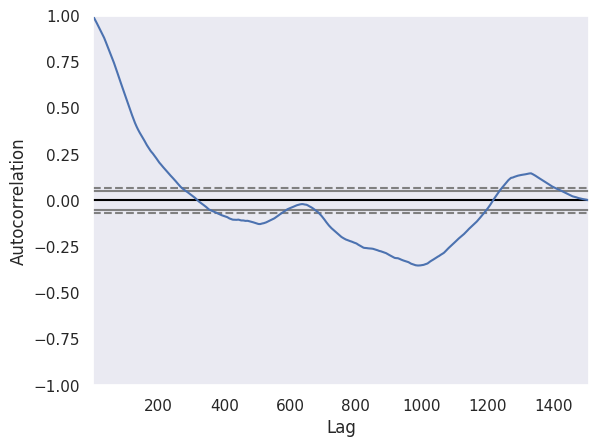

In [35]:
autocorrelation_plot(nflx_df['Close'])
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                   -1.882586
p-value                           0.340297
#Lags Used                        0.000000
Number of Observations Used    1509.000000
Critical Value (1%)              -3.434691
Critical Value (5%)              -2.863457
Critical Value (10%)             -2.567791
dtype: float64
Results of KPSS Test:
Test Statistic            2.298469
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


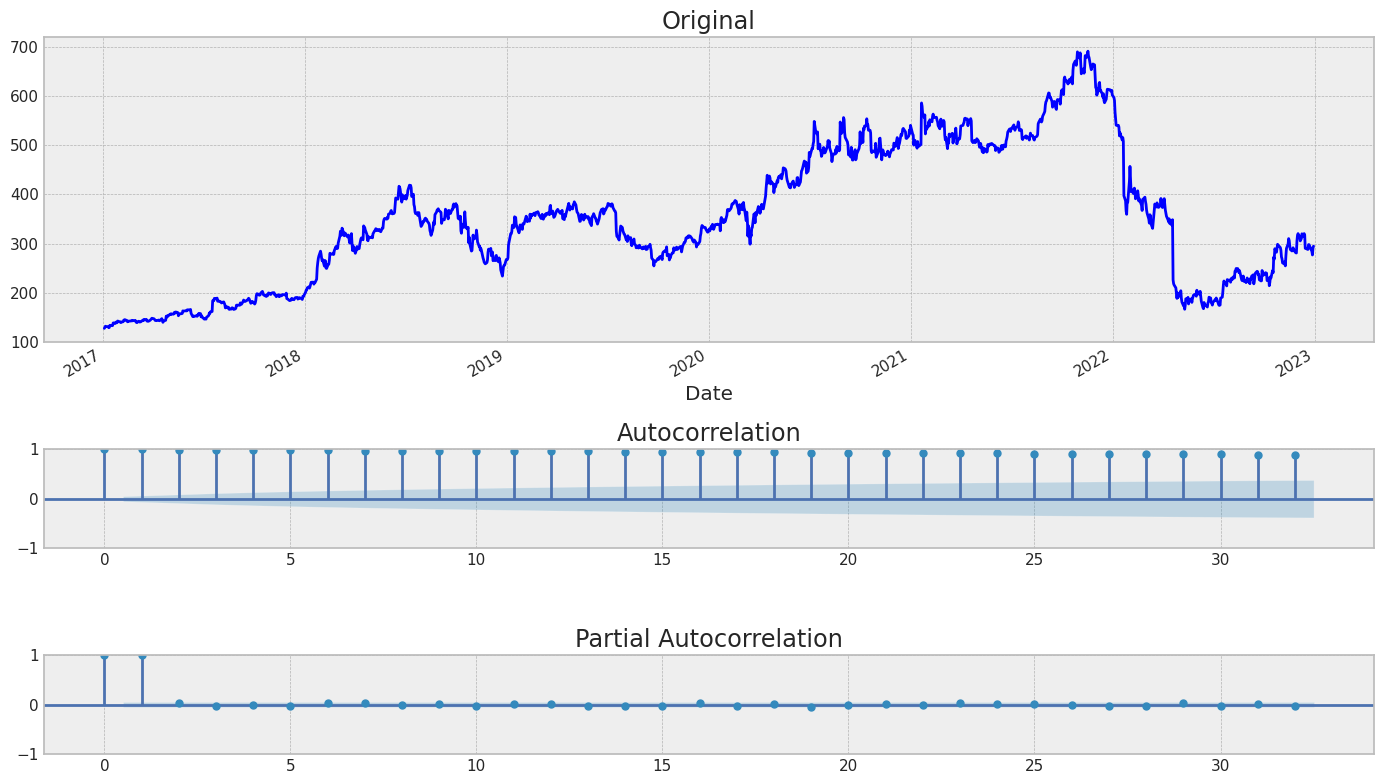

In [36]:
tsplot(nflx_df['Close'])

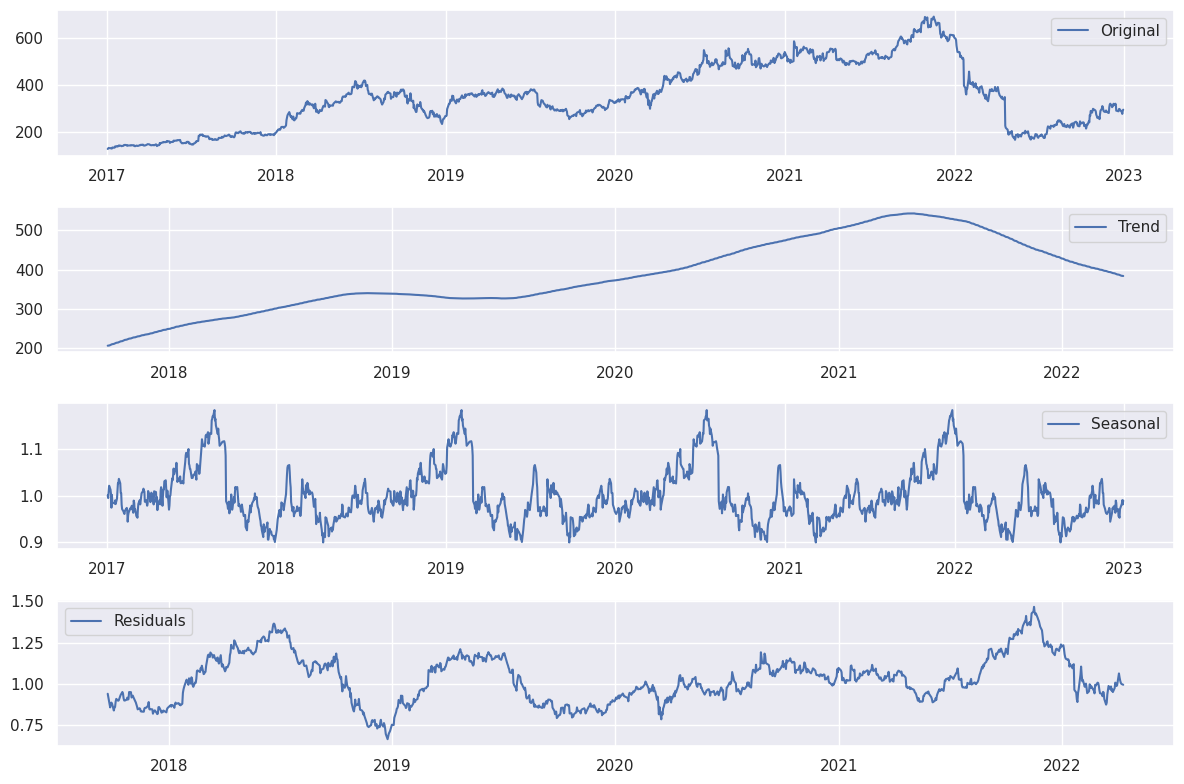

In [37]:
series_decompose(nflx_df['Close'])

# Make stationarity

Results of Dickey-Fuller Test:
Test Statistic                   -1.270556
p-value                           0.642533
#Lags Used                        9.000000
Number of Observations Used    1500.000000
Critical Value (1%)              -3.434717
Critical Value (5%)              -2.863469
Critical Value (10%)             -2.567797
dtype: float64
Results of KPSS Test:
Test Statistic            2.061724
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


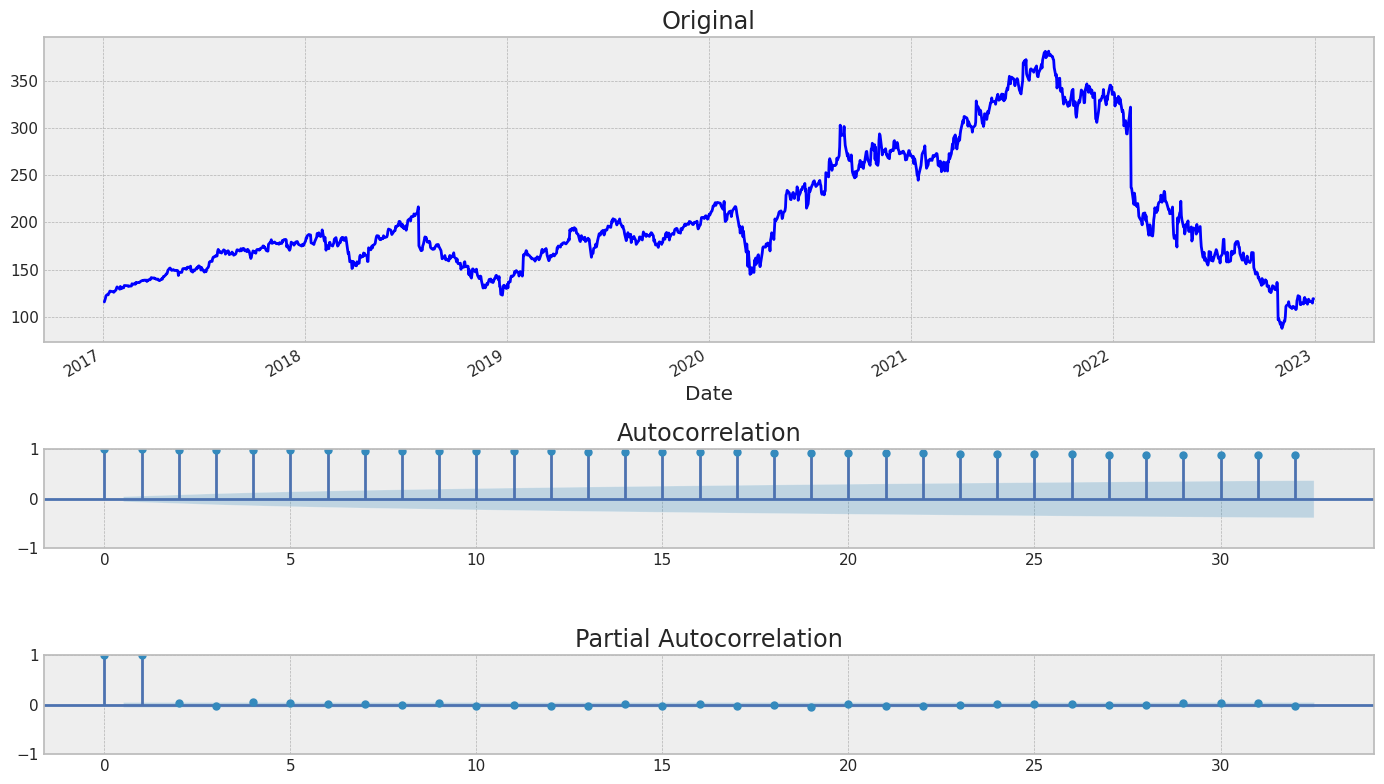

In [38]:
nflx_df['Close_boxcox'] = boxcox(nflx_df['Close'], 1)
tsplot(meta_df['Close_boxcox'])

Results of Dickey-Fuller Test:
Test Statistic                   -2.194802
p-value                           0.208138
#Lags Used                        2.000000
Number of Observations Used    1507.000000
Critical Value (1%)              -3.434697
Critical Value (5%)              -2.863460
Critical Value (10%)             -2.567792
dtype: float64
Results of KPSS Test:
Test Statistic            2.365159
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


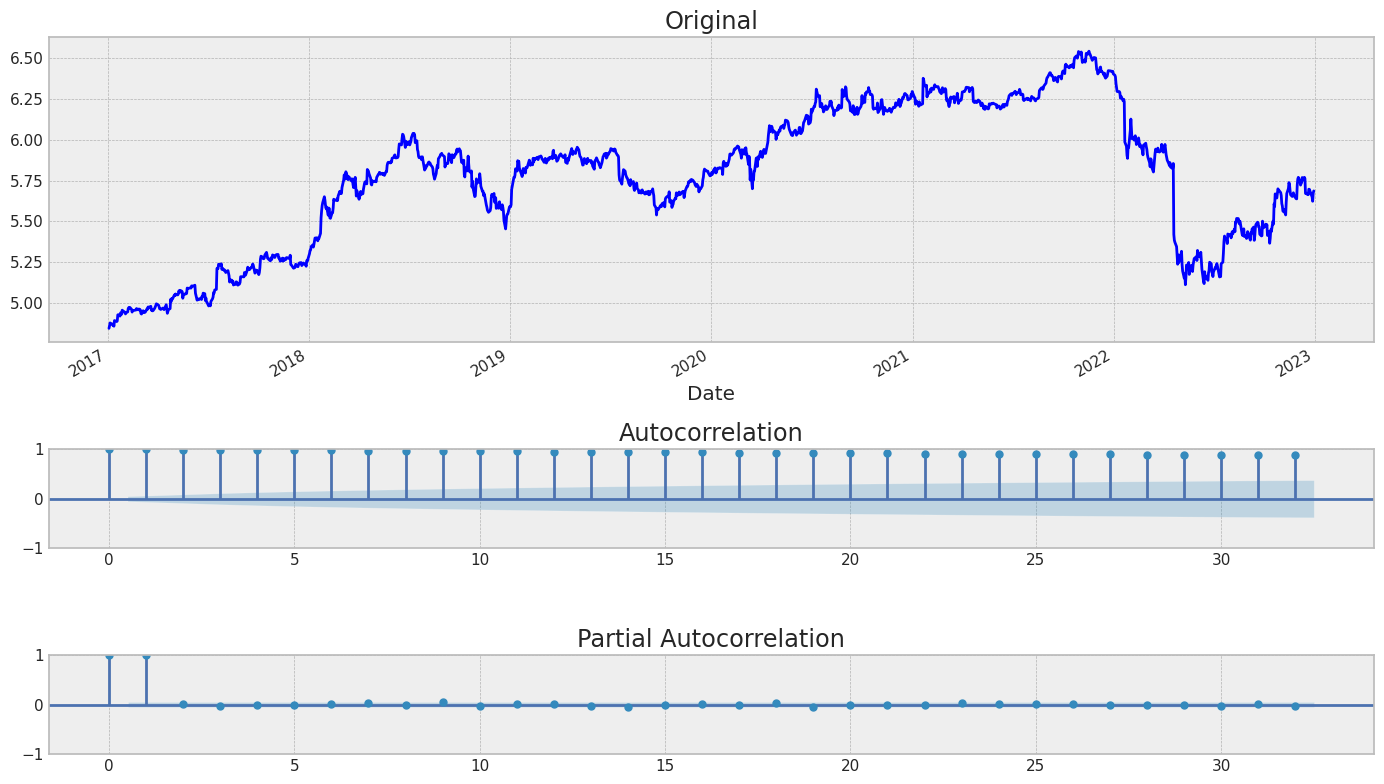

In [39]:
nflx_df['Close_log'] = np.log(nflx_df['Close'])
tsplot(nflx_df['Close_log'])

Results of Dickey-Fuller Test:
Test Statistic                  -40.316829
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1509.000000
Critical Value (1%)              -3.434691
Critical Value (5%)              -2.863457
Critical Value (10%)             -2.567791
dtype: float64
Results of KPSS Test:
Test Statistic           0.217599
p-value                  0.100000
#Lags Used               5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


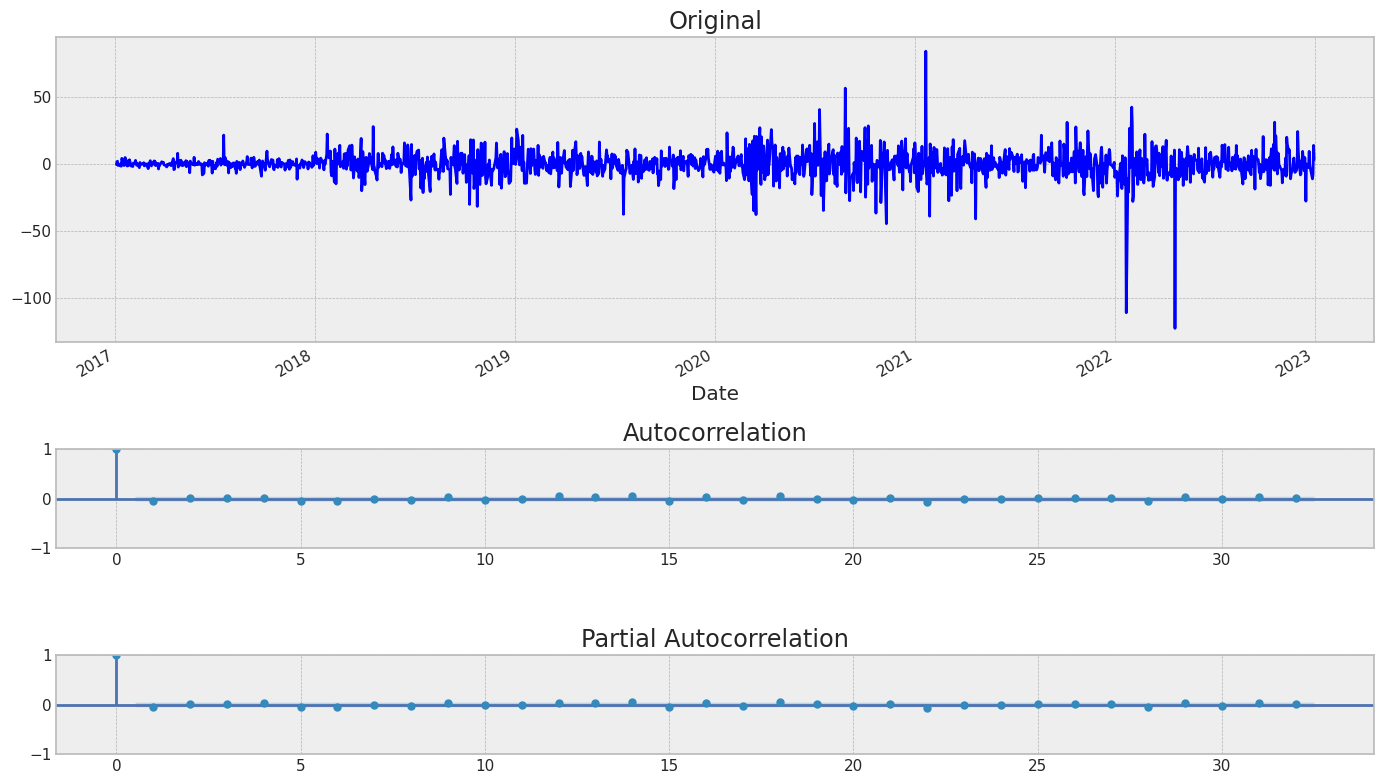

In [40]:
nflx_diff = np.diff(nflx_df['Close'],1)
nflx_df['Close_diff'] = np.append(0,nflx_diff)
tsplot(nflx_df['Close_diff'])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

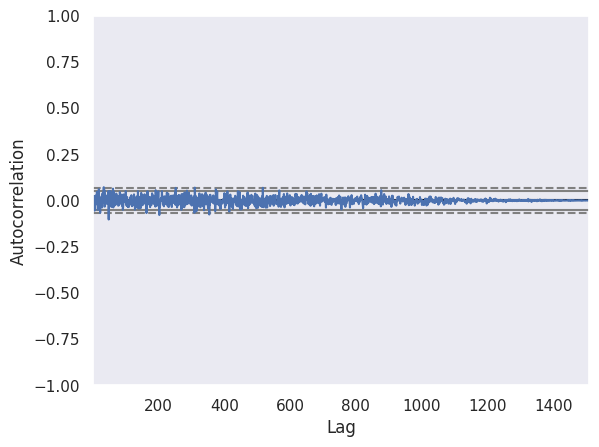

In [41]:
autocorrelation_plot(nflx_df['Close_diff'])

Results of Dickey-Fuller Test:
Test Statistic                  -3.529136
p-value                          0.007270
#Lags Used                      14.000000
Number of Observations Used    755.000000
Critical Value (1%)             -3.439041
Critical Value (5%)             -2.865376
Critical Value (10%)            -2.568813
dtype: float64
Results of KPSS Test:
Test Statistic            2.17879
p-value                   0.01000
#Lags Used               13.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


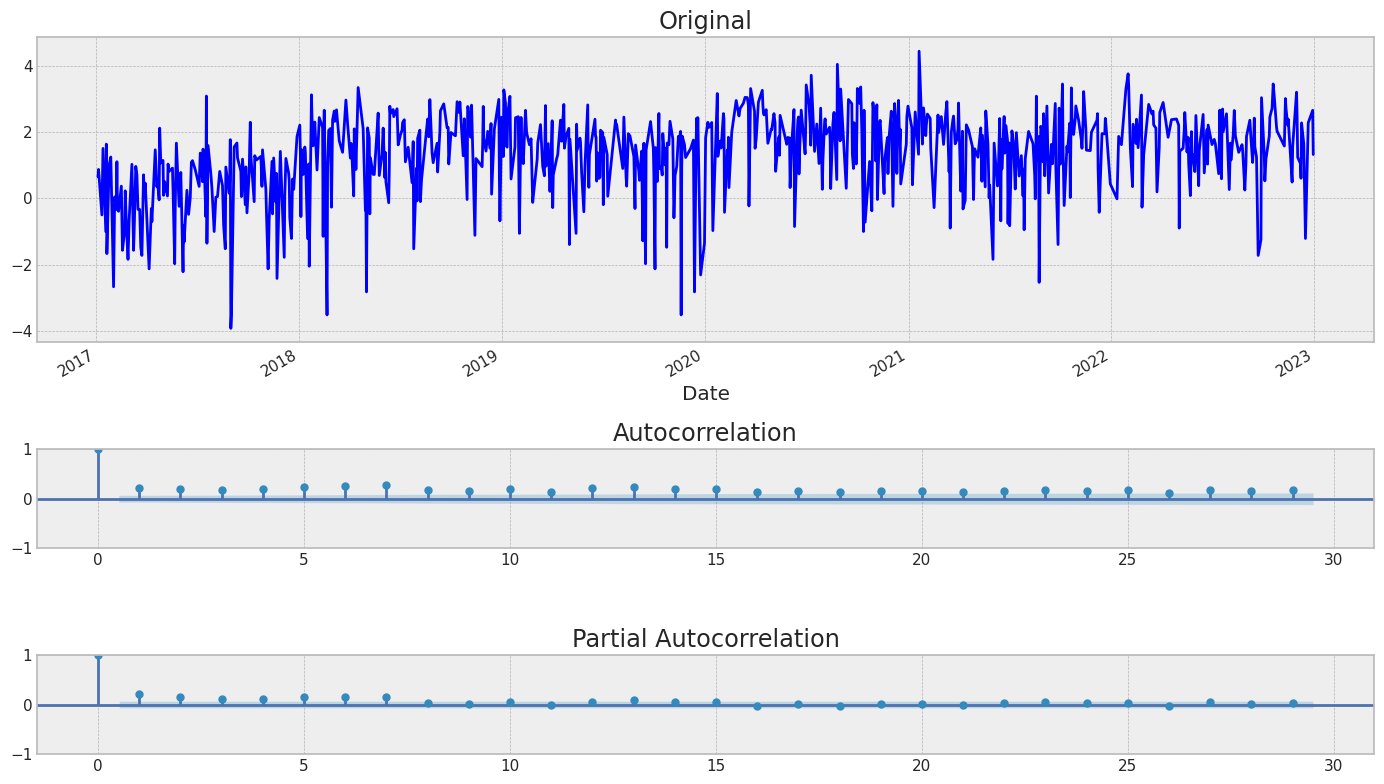

In [42]:
nflx_log = np.log(nflx_df['Close_diff']).replace([np.inf, -np.inf], np.nan).dropna()
tsplot(nflx_log)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

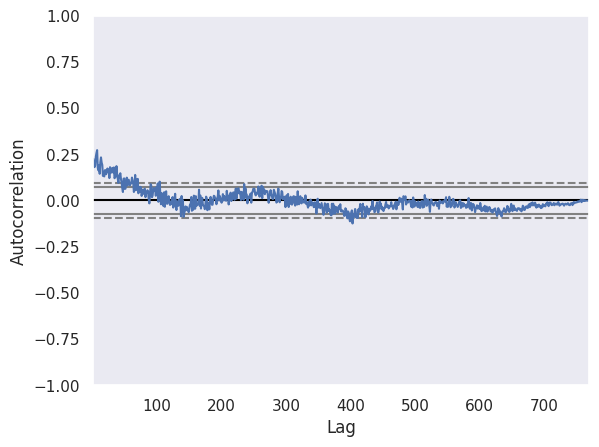

In [43]:
autocorrelation_plot(nflx_log)

# NFLX and META analysis

In [44]:
scaler = StandardScaler()
df = pd.DataFrame()

In [46]:
df['nflx_df'] = nflx_df['Close']
df['meta_df'] = meta_df['Close']

In [48]:
df[['nflx_df','meta_df']] = scaler.fit_transform(df)

In [52]:
(df['meta_df'].hvplot(width=800, height=500) *
df['nflx_df'].hvplot())

:Overlay
   .Curve.Meta_df :Curve   [Date]   (meta_df)
   .Curve.Nflx_df :Curve   [Date]   (nflx_df)

In [55]:
(df['nflx_df'].hvplot.line(width=800,height=500,by=['index.year'])+
 df['meta_df'].hvplot.line(width=800,height=500,by=['index.year']))

:Layout
   .NdOverlay.Nflx_df :NdOverlay   [index.year]
      :Curve   [Date]   (nflx_df)
   .NdOverlay.Meta_df :NdOverlay   [index.year]
      :Curve   [Date]   (meta_df)